# Quantum Computer lab 3 SOLUTIONS

These lab exercises are **NOT** part of the assesment of the module, but they should be useful training for the coursework.

* Please run the code to make sure it works, then try the questions.
* The idea is to explore the Shor algorithm written in pure python or implemented on the pennylane Quantum system
* This notebook contains a toolkit of the various parts of Shor's algorithm


##  Installing pennylane on the University machines and your laptop

There are instructions on how to install pennylane on your computer at: https://pennylane.ai/install/

In the annaconda prompt or terminal on a Mac type 

pip install pennylane --upgrade

If you have spyder running you may need to restart spyder to access the library.

You will have to run this command everytime you work on a new PC in the lab.

There may be  additional complications with the University PCs,because of administrative rights. 







## _*Shor's Algorithm for Integer Factorization*_ 

The latest version of this tutorial notebook is available on https://github.com/qiskit/qiskit-tutorial for the IBM quantum computer software.

In this tutorial, we first introduce the problem of integer factorization and describe how Shor's algorithm solves it in detail. We then study an implementation of period finding in Pennylane.
***
### History

This tutorial was modified by Craig McNeile, from one written by Anna Phan (https://github.com/qiskit/qiskit-tutorial), to use the Pennylane software instead of the IBM software.



## Integer Factorization <a id='factorization'></a>

Integer factorization is the decomposition of an composite integer into a product of smaller integers, for example, the integer $100$ can be factored into $10 \times 10$. If these factors are restricted to prime numbers, the process is called prime factorization, for example, the prime factorization of $100$ is $2 \times 2 \times 5 \times 5$. 

When the integers are very large, no efficient classical integer factorization algorithm is known. The hardest factorization problems are semiprime numbers, the product of two prime numbers. In [2009](https://link.springer.com/chapter/10.1007/978-3-642-14623-7_18), a team of researchers factored a 232 decimal digit semiprime number (768 bits), spending the computational equivalent of more than two thousand years on a single core 2.2 GHz AMD Opteron processor with 2 GB RAM:
```
RSA-768  = 12301866845301177551304949583849627207728535695953347921973224521517264005 
           07263657518745202199786469389956474942774063845925192557326303453731548268 
           50791702612214291346167042921431160222124047927473779408066535141959745985 
           6902143413 
           
         = 33478071698956898786044169848212690817704794983713768568912431388982883793 
           878002287614711652531743087737814467999489 
         × 36746043666799590428244633799627952632279158164343087642676032283815739666 
           511279233373417143396810270092798736308917 
```
The presumed difficulty of this semiprime factorization problem underlines many encryption algorithms, such as [RSA](https://www.google.com/patents/US4405829), which is used in online credit card transactions, amongst other applications.
***

## Shor's Algorithm <a id='shorsalgorithm'></a>

Shor's algorithm, named after mathematician Peter Shor, is a polynomial time quantum algorithm for integer factorization formulated in [1994](http://epubs.siam.org/doi/10.1137/S0097539795293172). It is arguably the most dramatic example of how the paradigm of quantum computing changed our perception of which computational problems should be considered tractable, motivating the study of new quantum algorithms and efforts to design and construct quantum computers. It also has expedited research into new cryptosystems not based on integer factorization. 

Shor's algorithm has been experimentally realised by multiple teams for specific composite integers. The composite $15$ was first factored into $3 \times 5$ in [2001](https://www.nature.com/nature/journal/v414/n6866/full/414883a.html) using seven NMR qubits, and has since been implemented using four photon qubits in 2007 by [two](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.99.250504) [teams](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.99.250505), three solid state qubits in [2012](https://www.nature.com/nphys/journal/v8/n10/full/nphys2385.html) and five trapped ion qubits in [2016](http://science.sciencemag.org/content/351/6277/1068). The composite $21$ has also been factored into $3 \times 7$ in [2012](http://www.nature.com/nphoton/journal/v6/n11/full/nphoton.2012.259.html) using a photon qubit and qutrit (a three level system). Note that these experimental demonstrations rely on significant optimisations of Shor's algorithm based on apriori knowledge of the expected results. In general, [$2 + \frac{3}{2}\log_2N$](https://link-springer-com.virtual.anu.edu.au/chapter/10.1007/3-540-49208-9_15) qubits are needed to factor the composite integer $N$, meaning at least $1,154$ qubits would be needed to factor $RSA-768$ above.


In [1]:
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/hOlOY7NyMfs?start=75&end=126",560,315)

As Peter Shor describes in the video above from [PhysicsWorld](http://physicsworld.com/cws/article/multimedia/2015/sep/30/what-is-shors-factoring-algorithm), Shor’s algorithm is composed of three parts. The first part turns the factoring problem into a period finding problem using number theory, which can be computed on a classical computer. The second part  finds the period using the quantum Fourier transform and is responsible for the quantum speedup of the algorithm. The third part uses the period found to calculate the factors.

The following sections go through the algorithm in detail, for those who just want the steps, without the lengthy explanation, refer to the [blue](#stepsone) [boxes](#stepstwo) before jumping down to the [implemention](#implemention). 

### From Factorization to Period Finding

The number theory that underlines Shor's algorithm relates to periodic modulo sequences. Let's have a look at an example of such a sequence. Consider the sequence of the powers of two: 
$$1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, ...$$
Now let's look at the same sequence 'modulo 15', that is, the remainder after fifteen divides each of these powers of two:
$$1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, ...$$
This is a modulo sequence that repeats every four numbers, that is, a periodic modulo sequence with a period of four.

Reduction of factorization of $N$ to the problem of finding the period of an integer $x$ less than $N$ and greater than $1$ depends on the following result from number theory:

> The function $\mathcal{F}(a) = x^a \bmod N$ is a periodic function, where $x$ is an integer coprime to $N$ and $a \ge 0$.

Note that two numbers are coprime, if the only positive integer that divides both of them is 1. This is equivalent to their greatest common divisor being 1. For example, 8 and 15 are coprime, as they don't share any common factors (other than 1). However, 9 and 15 are not coprime, since they are both divisible by 3 (and 1). 

> Since $\mathcal{F}(a)$ is a periodic function, it has some period $r$. Knowing that $x^0 \bmod N = 1$, this means that $x^r \bmod N = 1$ since the function is periodic, and thus $r$ is just the first nonzero power where $x^r = 1 (\bmod N)$.

Given this information and through the following algebraic manipulation: 
$$ x^r \equiv 1 \bmod N $$
$$ x^r = (x^{r/2})^2 \equiv 1 \bmod N $$
$$ (x^{r/2})^2 - 1 \equiv 0 \bmod N $$
and if $r$ is an even number:
$$ (x^{r/2} + 1)(x^{r/2} - 1) \equiv 0 \bmod N $$

From this, the product $(x^{r/2} + 1)(x^{r/2} - 1)$ is an integer multiple of $N$, the number to be factored. Thus, so long as $(x^{r/2} + 1)$ or $(x^{r/2} - 1)$ is not a multiple of $N$, then at least one of $(x^{r/2} + 1)$ or $(x^{r/2} - 1)$ must have a nontrivial factor in common with $N$. 

So computing $\text{gcd}(x^{r/2} - 1, N)$ and $\text{gcd}(x^{r/2} + 1, N)$ will obtain a factor of $N$, where $\text{gcd}$ is the greatest common denominator function, which can be calculated by the polynomial time [Euclidean algorithm](https://en.wikipedia.org/wiki/Euclidean_algorithm). 

#### Classical Steps to Shor's Algorithm

Let's assume for a moment that a period finding machine exists that takes as input coprime integers $x, N$ and outputs the period of $x \bmod N$, implemented by as a brute force search below. Let's show how to use the machine to find all prime factors of $N$ using the number theory described above. 

In [2]:
# Brute force period finding algorithm
def find_period_classical_store(x, N):
    n = 1
    t = x
    orbit = [t] 
    while t != 1:
        t *= x
        t %= N
        orbit.append(t)
        n += 1
        if n == 10 :
            break
    return n, orbit

In [3]:
# Brute force period finding algorithm
def find_period_classical(x, N):
    n = 1
    t = x
    orbit = [t] 
    while t != 1:
        t *= x
        t %= N
        orbit.append(t)
        n += 1
    return n

In [4]:
peroid, traj = find_period_classical_store(4, 15)
print("peroid = ", peroid)

peroid =  2


## Using python to compute gcd

**QUESTION**  Check the gcd functions from python.

In [5]:
#Import math Library
import math

#find the  the greatest common divisor of the two integers
print (math.gcd(3, 6))
print (math.gcd(6, 12))
print (math.gcd(12, 36))
print (math.gcd(-12, -36))
print (math.gcd(5, 12))

3
6
12
12
1


For simplicity, assume that $N$ has only two distinct prime factors: $N = pq$.

<div class="alert alert-block alert-info"> <a id='stepsone'></a>
<ol>
<li>Pick a random integer $x$ between $1$ and $N$ and compute the greatest common divisor $\text{gcd}(x,N)$ using Euclid's algorithm.</li>
<li>If $x$ and $N$ have some common prime factors, $\text{gcd}(x,N)$ will equal $p$ or $q$. Otherwise $\text{gcd}(x,N) = 1$, meaning $x$ and $N$ are coprime. </li>
<li>Let $r$ be the period of $x \bmod N$ computed by the period finding machine. Repeat the above steps with different random choices of $x$ until $r$ is even.</li>
<li>Now $p$ and $q$ can be found by computing $\text{gcd}(x^{r/2} \pm 1, N)$ as long as $x^{r/2} \neq \pm 1$.</li>
</ol>
</div>

**QUESTION** complete the table below.


As an example, consider $N = 15$. Let's look at all values of $1 < x < 15$ where $x$ is coprime with $15$:

|  $x$  |         $x^a \bmod 15$       | Period $r$ |$\text{gcd}(x^{r/2}-1,15)$|$\text{gcd}(x^{r/2}+1,15)$ | 
|:-----:|:----------------------------:|:----------:|:------------------------:|:-------------------------:|
|   2   | 1,2,4,8,1,2,4,8,1,2,4...     |      4     |             3            |             5             |
|   4   | 1,4,1,4,1,4,1,4,1,4,1...     |      2     |             3            |             5             |
|   7   | 1,7,4,13,1,7,4,13,1,7,4...   |      4      |             3            |             5             |
|   8   | 1,8,4,2,1,8,4,2,1,8,4...	4  |     4       |                3        |              5            |
|   11  |                              |            |                          |                           |
|   13  | 1,13,4,7,1,13,4,7,1,13,4,... |      4     |             3            |             5             |
|   14  | 1,14,1,14,1,14,1,14,1,14,1,,,|      2     |             1            |             15            |


As can be seen, any value of $x$ except $14$ will return the factors of $15$, that is, $3$ and $5$. $14$ is an example of the special case where $(x^{r/2} + 1)$ or $(x^{r/2} - 1)$ is a multiple of $N$ and thus another $x$ needs to be tried. 

In general, it can be shown that this special case occurs infrequently, so on average only two calls to the period finding machine are sufficient to factor $N$. 

##  Experiments with the classical Shor algorithm

The next python code creates the product of two prime numbers. It multiplies the two prime numbers to create a test number that the
classical Shor algorithm can factorise. Run the code. And answer the questions at the end.


For a more interesting example, first let's find larger number N, that is semiprime that is relatively small. Using the [Sieve of Eratosthenes](https://en.wikipedia.org/wiki/Sieve_of_Eratosthenes) [Python implementation](http://archive.oreilly.com/pub/a/python/excerpt/pythonckbk_chap1/index1.html?page=last), let's generate a list of all the prime numbers less than a thousand, randomly select two, and muliply them.

A semi-prime number is the product of two prime numbers  https://mathworld.wolfram.com/Semiprime.html

For your interest there is information about the itertools module from https://realpython.com/python-itertools/ (this module is inspired by functional programming techniques). You don't need to understand itertools to run the scripts.

In [6]:
import random, itertools

# Sieve of Eratosthenes algorithm
def sieve( ):
    D = {  }
    yield 2
    for q in itertools.islice(itertools.count(3), 0, None, 2):
        p = D.pop(q, None)
        if p is None:
            D[q*q] = q
            yield q
        else:
            x = p + q
            while x in D or not (x&1):
                x += p
            D[x] = p

# Creates a list of prime numbers up to the given argument
def get_primes_sieve(n):
    return list(itertools.takewhile(lambda p: p<n, sieve()))

def get_semiprime(n):
    primes = get_primes_sieve(n)
    l = len(primes)
    p = primes[random.randrange(l)]
    q = primes[random.randrange(l)]
    return p*q

N = get_semiprime(1000)

print("Test Number to be factored N =",N)

Test Number to be factored N = 42059


Now implement the [above steps](#stepsone) of Shor's Algorithm:

In [7]:
import math

def shors_algorithm_classical(N):
    x = random.randint(0,N) # step one
    if(math.gcd(x,N) != 1): # step two
        return x,0,math.gcd(x,N),N/math.gcd(x,N)
    r = find_period_classical(x,N) # step three
    while(r % 2 != 0):
        x = random.randint(0,N)
        r = find_period_classical(x,N)
    p = math.gcd(x**int(r/2)+1,N) # step four, ignoring the case where (x^(r/2) +/- 1) is a multiple of N
    q = math.gcd(x**int(r/2)-1,N)
    return x,r,p,q


In [8]:

import time
print("Number to be factored = " , N)
t_start = time.time()
x,r,p,q = shors_algorithm_classical(N)
t_end = time.time()

y = x**r%N
print(str(x) + "**" + str(r) , " mod" , N , " =" , y )
print("peroid = " , r)
print("p factor = " , int(p), "found")
print("q factor = " , int(q) , "found")
print("Test p*q = " , int(p*q))
print("Time to run classical Shor algorithm  = " , t_end - t_start , "s")

Number to be factored =  42059
32455**306  mod 42059  = 1
peroid =  306
p factor =  307 found
q factor =  137 found
Test p*q =  42059
Time to run classical Shor algorithm  =  0.000850677490234375 s


## Questions 

The above code can be used to test the various assumptions in Shor's algorithm, because we know the factors that constructed the number N to be factored.

* Does the above code work if N is the product of three prime factors?
* Does the above code work if N is the product of two large non-prime integers.
* The above code also calculates the amount of time to do the fctorization. Produce a graph of time taken to factorize the number N versus N.
*  Try using other python code to factorise an integer. For example  https://www.sanfoundry.com/python-program-compute-prime-factors-integer/


In [9]:
# try product of three prime integers
Ntest = 7*11*19
x,r,p,q = shors_algorithm_classical(Ntest)
print("p=", p)
print("q = ", q)
print("test ", p*q, Ntest)

# it works for this test case, because it produces two integer factors

p= 7
q =  209.0
test  1463.0 1463


In [10]:
# try product of two non-prime integers
Ntest = int(8*9)
x,r,p,q = shors_algorithm_classical(Ntest)
print("p=", p)
print("q = ", q)
print("test ", p*q, Ntest)

# it works for this test case, because it produces two integer factors.


p= 18
q =  4
test  72 72


6 3.314018249511719e-05
15 3.600120544433594e-05
35 2.6941299438476562e-05
77 6.079673767089844e-05
143 8.821487426757812e-05
221 4.696846008300781e-05
323 7.677078247070312e-05
437 0.0002124309539794922
667 0.00018262863159179688
899 1.8835067749023438e-05
1147 9.250640869140625e-05
1517 5.4836273193359375e-05
1763 0.00011563301086425781
2021 0.00017642974853515625
2491 0.0015413761138916016
3127 0.0009081363677978516
3599 0.0032296180725097656
4087 0.0008709430694580078
4757 0.0025320053100585938
5183 6.771087646484375e-05
5767 0.0004870891571044922
6557 0.002866506576538086
7387 0.0012345314025878906
8633 0.0002770423889160156
9797 0.0015115737915039062
10403 0.0010933876037597656


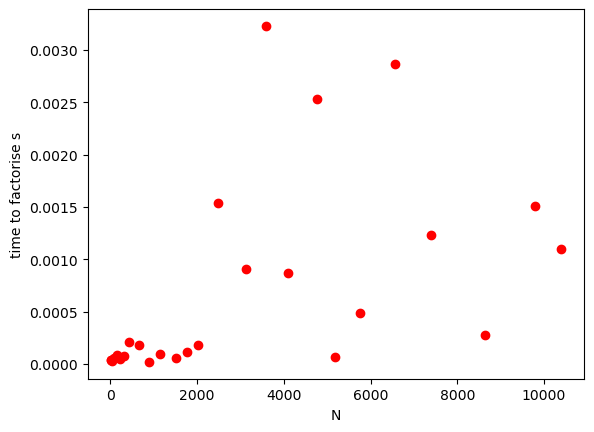

In [11]:
import time
#primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79]
primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103 ]
dim = len(primes)

Nstore = [] 
time_store = [] 
for i in range(1,dim):
    a = primes[i-1]
    b = primes[i]
    #print(a,b)
    N = a*b
    t_start = time.time()
    x,r,p,q = shors_algorithm_classical(N)
    t_end = time.time() - t_start
    print(N, t_end)
    Nstore.append(N)
    time_store.append(t_end)

#  plot the timings
import matplotlib.pyplot as plt
plt.xlabel('N')
plt.ylabel('time to factorise s')


plt.plot(Nstore, time_store, "ro")


### Quantum Period Finding <a id='quantumperiodfinding'></a>

Let's first describe the quantum period finding algorithm, and then go through a few of the steps in detail, before going through an example. This algorithm takes two coprime integers, $x$ and $N$, and outputs $r$, the period of $\mathcal{F}(a) = x^a\bmod N$.

<div class="alert alert-block alert-info"><a id='stepstwo'></a>
<ol>
<li> Choose $T = 2^t$ such that $N^2 \leq T \le 2N^2$. Initialise two registers of qubits, first an argument register with $t$ qubits and second a function register with $n = log_2 N$ qubits. These registers start in the initial state:
$$\vert\psi_0\rangle = \vert 0 \rangle \vert 0 \rangle$$ </li>
<li> Apply a Hadamard gate on each of the qubits in the argument register to yield an equally weighted superposition of all integers from $0$ to $T$:
$$\vert\psi_1\rangle = \frac{1}{\sqrt{T}}\sum_{a=0}^{T-1}\vert a \rangle \vert 0 \rangle$$ </li>
<li> Implement the modular exponentiation function $x^a \bmod N$ on the function register, giving the state:
$$\vert\psi_2\rangle = \frac{1}{\sqrt{T}}\sum_{a=0}^{T-1}\vert a \rangle \vert x^a \bmod N \rangle$$
This $\vert\psi_2\rangle$ is highly entangled and exhibits quantum parallism, i.e. the function entangled in parallel all the 0 to $T$ input values with the corresponding values of $x^a \bmod N$, even though the function was only executed once. </li>
<li> Perform a quantum Fourier transform on the argument register, resulting in the state:
$$\vert\psi_3\rangle = \frac{1}{T}\sum_{a=0}^{T-1}\sum_{z=0}^{T-1}e^{(2\pi i)(az/T)}\vert z \rangle \vert x^a \bmod N \rangle$$
where due to the interference, only the terms $\vert z \rangle$ with
$$z = qT/r $$
have significant amplitude where $q$ is a random integer ranging from $0$ to $r-1$ and $r$ is the period of $\mathcal{F}(a) = x^a\bmod N$. </li>
<li> Measure the argument register to obtain classical result $z$. With reasonable probability, the continued fraction approximation of $T / z$ will be an integer multiple of the period $r$. Euclid's algorithm can then be used to find $r$.</li>
</ol>
</div>

Note how quantum parallelism and constructive interference have been used to detect and measure periodicity of the modular exponentiation function.  The fact that interference makes it easier to measure periodicity should not come as a big surprise. After all, physicists routinely use scattering of electromagnetic waves and interference measurements to determine periodicity of physical objects such as crystal lattices. Likewise, Shor's algorithm exploits interference to measure periodicity of arithmetic objects, a computational interferometer of sorts. 

####  Modular Exponentiation

The modular exponentiation, step 3 above, that is the evaluation of $x^a \bmod N$ for $2^t$ values of $a$ in parallel, is the most demanding part of the algorithm. This can be performed using the following identity for the binary representation of any integer: $x = x_{t-1}2^{t-1} + ... x_12^1+x_02^0$, where $x_t$ are the binary digits of $x$. From this, it follows that:

\begin{aligned}
x^a \bmod N & = x^{2^{(t-1)}a_{t-1}} ... x^{2a_1}x^{a_0} \bmod N \\
& = x^{2^{(t-1)}a_{t-1}} ... [x^{2a_1}[x^{2a_0} \bmod N] \bmod N] ... \bmod N \\
\end{aligned}

This means that 1 is first multiplied by $x^1 \bmod N$ if and only if $a_0 = 1$, then the result is multiplied by $x^2 \bmod N$ if and only if $a_1 = 1$ and so forth, until finally the result is multiplied by $x^{2^{(s-1)}}\bmod N$ if and only if $a_{t-1} = 1$. 

Therefore, the modular exponentiation consists of $t$ serial multiplications modulo $N$, each of them controlled by the qubit $a_t$. The values $x,x^2,...,x^{2^{(t-1)}} \bmod N$ can be found efficiently on a classical computer by repeated squaring.

#### Quantum Fourier Transform

The Fourier transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The quantum Fourier transform (QFT), step 4 above, is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction. 

The classical discrete Fourier transform acts on a vector $(x_0, ..., x_{N-1})$ and maps it to the vector $(y_0, ..., y_{N-1})$ according to the formula
$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$
where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.

Similarly, the quantum Fourier transform acts on a quantum state $\sum_{i=0}^{N-1} x_i \vert i \rangle$ and maps it to the quantum state $\sum_{i=0}^{N-1} y_i \vert i \rangle$ according to the formula
$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$
with $\omega_N^{jk}$ defined as above. Note that only the amplitudes of the state were affected by this transformation.

This can also be expressed as the map:
$$\vert x \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle$$

Or the unitary matrix:
$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} \omega_N^{xy} \vert y \rangle \langle x \vert$$

#### Quantum Fourier Transform

The Fourier transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The quantum Fourier transform (QFT), step 4 above, is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction. 

The classical discrete Fourier transform acts on a vector $(x_0, ..., x_{N-1})$ and maps it to the vector $(y_0, ..., y_{N-1})$ according to the formula
$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$
where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.

Similarly, the quantum Fourier transform acts on a quantum state $\sum_{i=0}^{N-1} x_i \vert i \rangle$ and maps it to the quantum state $\sum_{i=0}^{N-1} y_i \vert i \rangle$ according to the formula
$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$
with $\omega_N^{jk}$ defined as above. Note that only the amplitudes of the state were affected by this transformation.

This can also be expressed as the map:
$$\vert x \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle$$

Or the unitary matrix:
$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} \omega_N^{xy} \vert y \rangle \langle x \vert$$

As an example, we've actually already seen the quantum Fourier transform for when $N = 2$, it is the Hadamard operator ($H$):
$$H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$$
Suppose we have the single qubit state $\alpha \vert 0 \rangle + \beta \vert 1 \rangle$, if we apply the $H$ operator to this state, we obtain the new state:
$$\frac{1}{\sqrt{2}}(\alpha + \beta) \vert 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  \vert 1 \rangle 
\equiv \tilde{\alpha}\vert 0 \rangle + \tilde{\beta}\vert 1 \rangle$$
Notice how the Hadamard gate performs the discrete Fourier transform for $N = 2$ on the amplitudes of the state. 

So what does the quantum Fourier transform look like for larger N? Let's derive a circuit for $N=2^n$, $QFT_N$ acting on the state $\vert x \rangle = \vert x_1...x_n \rangle$ where $x_1$ is the most significant bit.
\begin{aligned}
QFT_N\vert x \rangle & = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle \\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i xy / 2^n} \vert y \rangle \:\text{since}\: \omega_N^{xy} = e^{2\pi i \frac{xy}{N}} \:\text{and}\: N = 2^n\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} \vert y_1 ... y_n \rangle \:\text{rewriting in fractional binary notation}\: y = y_1...y_k, y/2^n = \sum_{k=1}^n y_k/2^k \\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=0}^n e^{2 \pi i x y_k/2^k } \vert y_1 ... y_n \rangle \:\text{after expanding the exponential of a sum to a product of exponentials} \\
& = \frac{1}{\sqrt{N}} \bigotimes_{k=1}^n  \left(\vert0\rangle + e^{2 \pi i x /2^k } \vert1\rangle \right) \:\text{after rearranging the sum and products, and expanding} \\
& = \frac{1}{\sqrt{N}} \left(\vert0\rangle + e^{2 \pi i[0.x_n]} \vert1\rangle\right) \otimes...\otimes  \left(\vert0\rangle + e^{2 \pi i[0.x_1.x_2...x_{n-1}.x_n]} \vert1\rangle\right) \:\text{as}\: e^{2 \pi i x/2^k} = e^{2 \pi i[0.x_k...x_n]} 
\end{aligned}

This is a very useful form of the QFT for $N=2^n$ as only the last qubit depends on the the
values of all the other input qubits and each further bit depends less and less on the input qubits. Furthermore, note that $e^{2 \pi i.0.x_n}$ is either $+1$ or $-1$, which resembles the Hadamard transform.

Before we create the circuit code for general $N=2^n$, let's look at $N=8,n=3$:
$$QFT_8\vert x_1x_2x_3\rangle = \frac{1}{\sqrt{8}} \left(\vert0\rangle + e^{2 \pi i[0.x_3]} \vert1\rangle\right) \otimes \left(\vert0\rangle + e^{2 \pi i[0.x_2.x_3]} \vert1\rangle\right) \otimes  \left(\vert0\rangle + e^{2 \pi i[0.x_1.x_2.x_3]} \vert1\rangle\right) $$

The steps to creating the circuit for $\vert y_1y_2x_3\rangle = QFT_8\vert x_1x_2x_3\rangle$, remembering the [controlled phase rotation gate](../tools/quantum_gates_and_linear_algebra.ipynb
) $CU_1$, would be:
1. Apply a Hadamard to $\vert x_3 \rangle$, giving the state $\frac{1}{\sqrt{2}}\left(\vert0\rangle + e^{2 \pi i.0.x_3} \vert1\rangle\right) = \frac{1}{\sqrt{2}}\left(\vert0\rangle + (-1)^{x_3} \vert1\rangle\right)$
2. Apply a Hadamard to $\vert x_2 \rangle$, then depending on $k_3$ (before the Hadamard gate) a $CU_1(\frac{\pi}{2})$, giving the state $\frac{1}{\sqrt{2}}\left(\vert0\rangle + e^{2 \pi i[0.x_2.x_3]} \vert1\rangle\right)$.
3. Apply a Hadamard to $\vert x_1 \rangle$, then $CU_1(\frac{\pi}{2})$ depending on $k_2$, and $CU_1(\frac{\pi}{4})$ depending on $k_3$.
4. Measure the bits in reverse order, that is $y_3 = x_1, y_2 = x_2, y_1 = y_3$.




## Shor implementation in the Pennylane system

In this problem we look at an implementation of peroid finding in the Pennylane system. This is the time critical part of factorising an integer into primes.

This is not a generic implementation. The modular arithmetic is hard coded to factorise 15.

The code came from https://quantumcomputing.stackexchange.com/questions/23555/implementation-of-unitary-in-shors-algorithm-in-pennylane


In [12]:
import pennylane as qml
import numpy as np
import math


The author of the code wrote their own Quantum Phase Estimation code.

In [13]:
def QFT(wires):
    for i in range(len(wires)):
        qml.Hadamard(wires=wires[i])
        for j in range(i):
            qml.CRZ(math.pi/2**(i - j),wires=[wires[i],wires[j]])



This is code to apply a**(power) mod 15

In [14]:
def c_amod15(a, power):
    for iteration in range(power):
        if a in [2, 13]:
            qml.SWAP(wires = [8, 9])
            qml.SWAP(wires = [9, 10])
            qml.SWAP(wires = [10, 11])
        if a in [7, 8]:
            qml.SWAP(wires = [10, 11])
            qml.SWAP(wires = [9, 10])
            qml.SWAP(wires = [8, 9])
        if a in [4,11] :
            qml.SWAP(wires = [9, 11])
            qml.SWAP(wires = [8, 10])
        if a in [7, 11, 13]:
            for k in range(8, 12):
                qml.PauliX(wires = k)


In [15]:
# https://stackoverflow.com/questions/13662933/how-to-convert-a-string-representing-a-binary-fraction-to-a-number-in-python
def frac_bin_str_to_float(num):
    """Assuming num to be a string representing
    the fractional part of a binary number with
    no integer part, return num as a float."""
    result = 0
    ex = 2.0
    for c in num:
        if c == '1':
            result += 1/ex 
        ex *= 2
    return result



In [19]:
n_count = 8
dev = qml.device('default.qubit', wires = n_count + 4, shots = 10000)

@qml.qnode(dev)
def circuit(a):
    """
    The Quantum Circuit
    """
    N = 15

    print("a = ", a)
    if math.gcd(a, N) != 1:
        raise ValueError("Non-trivial factor.")
    
    for k in range(0, 8):
        qml.Hadamard(wires = k)

    qml.PauliX(wires = n_count + 3)

    for k in range(0, 8):
        qml.ctrl(c_amod15, control = k)(a, 2**k)

    qml.adjoint(QFT)(wires = [0, 1, 2, 3, 4, 5, 6, 7])

    return qml.probs(wires=range(0, 8))


### Find the period

For a given integer a < 15 this quantum circuit finds the period r

$$ a^r \;\; mod \;\; 15 = 1  $$

8 qubits are used to estimate the variable r
4 qubits are used to represent the matrix that applies the modular arithmetic


In [20]:
#n_count = 8

#dev = qml.device('default.qubit', wires = n_count + 4, shots = 10000)
ans = circuit(7)

estimation_wires = range(0, n_count)
bit_strings = [f"0.{x:0{len(estimation_wires)}b}" for x in range(len(ans))]

# output the results with the highest probability 
for b_,p_ in zip(bit_strings, ans):
    if p_ > 0.015 :
        bf =  frac_bin_str_to_float(b_[2:])
        print(b_,bf, p_ )



a =  7
0.00000000 0 0.0441
0.00100000 0.125 0.0154
0.00111110 0.2421875 0.0156
0.01000000 0.25 0.0462
0.01100000 0.375 0.0161
0.10000000 0.5 0.046
0.10111110 0.7421875 0.0164
0.11000000 0.75 0.0473
0.11111100 0.984375 0.0153


### Question 

* From the lecture notes extract the period $r$ from the binary output.
* Reduce the probability threshold of 0.015 to print out the binary states. 


## Continued fractions in python
The symbolic module (https://www.sympy.org/en/index.html) in python has routines to work with continued fractions.

https://mathworld.wolfram.com/ContinuedFraction.html

This exercise just investigates the continued fraction code in sympy module.


In [21]:
from sympy.physics.quantum.shor import continued_fraction

# test it on the example in wikepedia https://en.wikipedia.org/wiki/Continued_fraction
ans =  continued_fraction(415,93 )
print(ans)

##help(continued_fraction)


[4, 2, 6, 7]


**QUESTION**
In the lecture on Shor's algorithm it was shown that the continued fraction expansion of 0.1562 was [0,6,2,2,19,8]
Use the above python to compute the continued fraction expansion of 0.1562

Write some python code to compute the **convergents** of the  continued fraction expansion

* eg 0th convergent = 0 
* eg 1st convergent = 1/6